# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

本笔记本展示了如何在您自己的数据集上训练 Mask R-CNN。 为了简单起见，我们使用形状（正方形、三角形和圆形）的合成数据集，以实现快速训练。 不过，您仍然需要 GPU，因为网络主干是 Resnet101，在 CPU 上训练速度太慢。 在 GPU 上，您可以在几分钟内开始获得不错的结果，并在不到一个小时内获得良好的结果。

*Shapes* 数据集的代码如下所示。 它即时生成图像，因此不需要下载任何数据。 它可以生成任意大小的图像，因此我们选择较小的图像大小来更快地训练。

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file训练权重文件的本地路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    玩具形状数据集的训练配置。
    从基本 Config 类派生并覆盖特定于玩具形状数据集的值。
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # 在 1 个 GPU 上训练，每个 GPU 上训练 8 个图像。 我们可以在每个 GPU 上放置多个图像，因为图像很小。 批量大小为 8（GPU * 图像/GPU）。
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # 使用小图像进行更快的训练。 设置小边和大边的界限，这决定了图像的形状。
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    # 使用较小的锚点，因为我们的图像和对象很小
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # 减少每张图像的训练 ROI，因为图像很小且对象很少。 旨在让 ROI 采样能够选择 33% 的正 ROI。
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    
    返回要在笔记本中的所有可视化中使用的 Matplotlib Axes 数组。 提供一个中心点来控制图形大小。

    更改默认大小属性以控制渲染图像的大小
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset创建合成数据集

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:
扩展 Dataset 类并添加一个方法来加载形状数据集，`load_shapes()`，并覆盖以下方法：

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    生成形状合成数据集。 数据集由随机放置在空白表面上的简单形状（三角形、正方形、圆形）组成。
    图像是即时生成的。 无需文件访问。
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        生成请求数量的合成图像。
        count：要生成的图像数量。
        高度，宽度：生成图像的大小。
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
#         生成图像的随机规格（即颜色和形状大小和位置列表）。 这比实际图像更紧凑。 图像在 load_image() 中动态生成。
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        根据给定图像 ID 的规格生成图像。
        通常，此函数从文件加载图像，但在这种情况下，它会根据 image_info 中的规范动态生成图像。
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.为给定图像 ID 的形状生成实例掩码。
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs.根据给定的规格绘制形状。"""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        生成位于给定高度和宽度边界内的随机形状的规范。
        返回三个值的元组：
        * 形状名称（方形，圆形，...）
        * 形状颜色：3 个值的元组，RGB。
        * 形状尺寸：定义形状大小和位置的值元组。 因形状类型而异。
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        创建具有多种形状的图像的随机规格。
        返回图像的背景颜色和可用于绘制图像的形状规范列表。
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their bounding boxes
#         生成一些随机形状并记录它们的边界框
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid shapes covering each other
#         应用 0.3 阈值的非最大抑制以避免形状相互覆盖
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

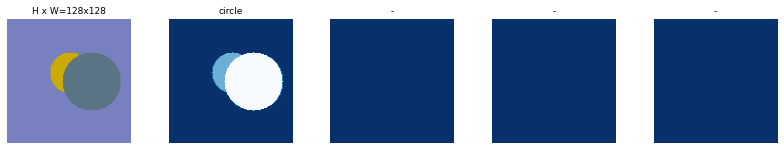

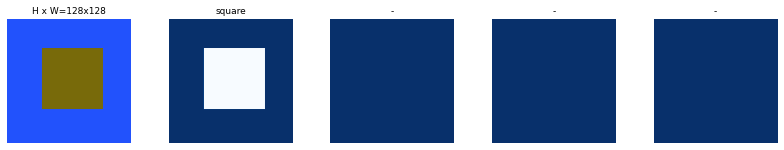

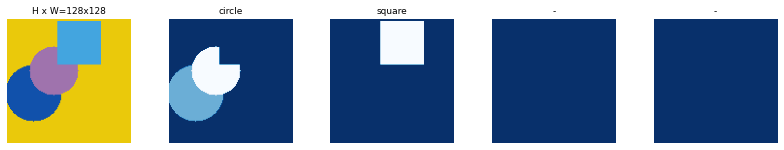

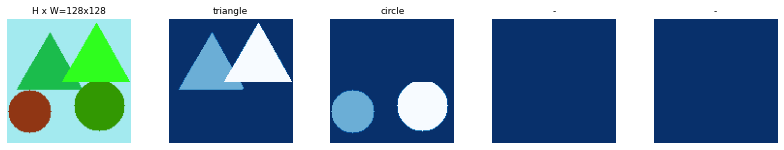

In [6]:
# Load and display random samples加载并显示随机样本
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode在训练模式下创建模型
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    # 加载在 MS COCO 上训练的权重，但由于类数不同而跳过不同的层。有关下载 COCO 权重的说明，请参阅自述文件
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

1. 只有头。 在这里，我们冻结了所有的主干层并只训练随机初始化的层（即我们没有使用来自 MS COCO 的预训练权重的层）。 要仅训练头部层，请将 `layers='heads'` 传递给 `train()` 函数。

2. 微调所有层。 对于这个简单的示例，它不是必需的，但我们将其包括在内以显示该过程。 只需通过 `layers="all` 来训练所有层。

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# 训练头部分支
# 传递 layers="heads" 冻结除头层之外的所有层。 您还可以传递正则表达式来选择要按名称模式训练的层。
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\XMJ\Courseware\Lab\Mask_RCNN\logs\shapes20220510T2041\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


E:\XMJ\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
100/100 [==============================] - 80s 805ms/step - loss: 1.8183 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.5986 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.4887 - val_loss: 1.1172 - val_rpn_class_loss: 0.0189 - val_rpn_bbox_loss: 0.4651 - val_mrcnn_class_loss: 0.2105 - val_mrcnn_bbox_loss: 0.2159 - val_mrcnn_mask_loss: 0.2069


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
# 微调所有层
# 通过 layers="all" 训练所有层。 您还可以传递正则表达式来选择要按名称模式训练的层。
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: E:\Courseware\lab\Mask_RCNN\logs\shapes20220410T1255\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  1/100 [..............................] - ETA: 1:37:34 - loss: 1.0130 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4425 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.1900

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  2/100 [..............................] - ETA: 1:21:52 - loss: 0.9371 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.1515

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  3/100 [..............................] - ETA: 1:15:02 - loss: 0.9482 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4439 - mrcnn_class_loss: 0.1680 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.1474

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  4/100 [>.............................] - ETA: 1:12:31 - loss: 0.8921 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.1544 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.1306

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  5/100 [>.............................] - ETA: 1:12:43 - loss: 0.8624 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.1354

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  6/100 [>.............................] - ETA: 1:12:37 - loss: 0.8745 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.1423

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  7/100 [=>............................] - ETA: 1:10:49 - loss: 0.9148 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.1526

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  8/100 [=>............................] - ETA: 1:08:47 - loss: 0.9144 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.1511

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

  9/100 [=>............................] - ETA: 1:06:59 - loss: 0.9258 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4359 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.1481

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 10/100 [==>...........................] - ETA: 1:04:57 - loss: 0.9487 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4478 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.1524

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 11/100 [==>...........................] - ETA: 1:03:20 - loss: 0.9573 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4531 - mrcnn_class_loss: 0.1606 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.1556

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 12/100 [==>...........................] - ETA: 1:02:04 - loss: 0.9431 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.1505

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 13/100 [==>...........................] - ETA: 1:00:37 - loss: 0.9432 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.1507

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 14/100 [===>..........................] - ETA: 59:29 - loss: 0.9339 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.1507  

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 15/100 [===>..........................] - ETA: 58:18 - loss: 0.9449 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.1584

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 16/100 [===>..........................] - ETA: 57:10 - loss: 0.9351 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1536

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 17/100 [====>.........................] - ETA: 56:11 - loss: 0.9311 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4375 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.1513

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 18/100 [====>.........................] - ETA: 55:06 - loss: 0.9322 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.1519

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 19/100 [====>.........................] - ETA: 54:16 - loss: 0.9358 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.1527

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 20/100 [=====>........................] - ETA: 53:30 - loss: 0.9308 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.1501

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 21/100 [=====>........................] - ETA: 52:39 - loss: 0.9213 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4404 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.1479

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 22/100 [=====>........................] - ETA: 51:50 - loss: 0.9165 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.1563 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1462

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 23/100 [=====>........................] - ETA: 51:15 - loss: 0.9130 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4431 - mrcnn_class_loss: 0.1533 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.1432

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 24/100 [======>.......................] - ETA: 50:31 - loss: 0.9039 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4418 - mrcnn_class_loss: 0.1504 - mrcnn_bbox_loss: 0.1535 - mrcnn_mask_loss: 0.1408

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 25/100 [======>.......................] - ETA: 49:40 - loss: 0.9071 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.1535 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1421

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 26/100 [======>.......................] - ETA: 48:48 - loss: 0.9071 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.1527 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.1414

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 27/100 [=======>......................] - ETA: 48:01 - loss: 0.9016 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 28/100 [=======>......................] - ETA: 47:16 - loss: 0.9010 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1402

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 29/100 [=======>......................] - ETA: 46:32 - loss: 0.8957 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 30/100 [========>.....................] - ETA: 45:54 - loss: 0.8962 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1419

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 31/100 [========>.....................] - ETA: 45:10 - loss: 0.8943 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1412

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 32/100 [========>.....................] - ETA: 44:25 - loss: 0.8866 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1391

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 33/100 [========>.....................] - ETA: 43:39 - loss: 0.8876 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1399

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 34/100 [=========>....................] - ETA: 42:54 - loss: 0.8939 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1416

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 35/100 [=========>....................] - ETA: 42:09 - loss: 0.9032 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1460

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 36/100 [=========>....................] - ETA: 41:23 - loss: 0.9033 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4384 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1463

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 37/100 [==========>...................] - ETA: 40:40 - loss: 0.9009 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1460

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 38/100 [==========>...................] - ETA: 39:56 - loss: 0.8949 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4362 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1442

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 39/100 [==========>...................] - ETA: 39:14 - loss: 0.8909 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.1481 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1436

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 40/100 [===========>..................] - ETA: 38:30 - loss: 0.8839 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4310 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1423

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 41/100 [===========>..................] - ETA: 37:47 - loss: 0.8788 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4310 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1406

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 42/100 [===========>..................] - ETA: 37:06 - loss: 0.8730 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4284 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1395

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 43/100 [===========>..................] - ETA: 36:25 - loss: 0.8696 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4273 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1390

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 44/100 [============>.................] - ETA: 35:44 - loss: 0.8667 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4252 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1389

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 45/100 [============>.................] - ETA: 35:03 - loss: 0.8647 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1401

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 46/100 [============>.................] - ETA: 34:22 - loss: 0.8647 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1409

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 47/100 [=============>................] - ETA: 33:41 - loss: 0.8667 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1410

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 48/100 [=============>................] - ETA: 33:00 - loss: 0.8651 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1410

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 49/100 [=============>................] - ETA: 32:20 - loss: 0.8620 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1403

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 50/100 [==============>...............] - ETA: 31:41 - loss: 0.8641 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1419

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 51/100 [==============>...............] - ETA: 31:01 - loss: 0.8628 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1419

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 52/100 [==============>...............] - ETA: 30:22 - loss: 0.8640 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4187 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1417

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 53/100 [==============>...............] - ETA: 29:42 - loss: 0.8662 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1427

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 54/100 [===============>..............] - ETA: 29:05 - loss: 0.8659 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4201 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1419

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 55/100 [===============>..............] - ETA: 28:25 - loss: 0.8652 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4192 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1420

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 56/100 [===============>..............] - ETA: 27:45 - loss: 0.8627 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4187 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1412

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 57/100 [================>.............] - ETA: 27:06 - loss: 0.8638 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1426

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 58/100 [================>.............] - ETA: 26:28 - loss: 0.8647 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4193 - mrcnn_class_loss: 0.1424 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1426

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 59/100 [================>.............] - ETA: 25:48 - loss: 0.8621 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4184 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1419

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 60/100 [=================>............] - ETA: 25:09 - loss: 0.8612 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.1410

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 61/100 [=================>............] - ETA: 24:30 - loss: 0.8590 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1398

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 62/100 [=================>............] - ETA: 23:51 - loss: 0.8612 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 63/100 [=================>............] - ETA: 23:12 - loss: 0.8634 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4243 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1407

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 64/100 [==================>...........] - ETA: 22:33 - loss: 0.8620 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4249 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1402

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 65/100 [==================>...........] - ETA: 21:55 - loss: 0.8615 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4270 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.1392

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 66/100 [==================>...........] - ETA: 21:16 - loss: 0.8587 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1385

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 67/100 [===================>..........] - ETA: 20:38 - loss: 0.8587 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1387

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 68/100 [===================>..........] - ETA: 19:59 - loss: 0.8599 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4266 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1390

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 69/100 [===================>..........] - ETA: 19:22 - loss: 0.8601 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.1390

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 70/100 [====================>.........] - ETA: 18:43 - loss: 0.8586 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1390

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 71/100 [====================>.........] - ETA: 18:05 - loss: 0.8595 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4258 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.1391

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 72/100 [====================>.........] - ETA: 17:27 - loss: 0.8582 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.1393

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 73/100 [====================>.........] - ETA: 16:49 - loss: 0.8603 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1382 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.1395

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 74/100 [=====================>........] - ETA: 16:11 - loss: 0.8592 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.1376 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 75/100 [=====================>........] - ETA: 15:33 - loss: 0.8593 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.1373 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1394

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 76/100 [=====================>........] - ETA: 14:55 - loss: 0.8612 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4280 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1401

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 77/100 [======================>.......] - ETA: 14:17 - loss: 0.8603 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4279 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 78/100 [======================>.......] - ETA: 13:39 - loss: 0.8586 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4274 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.1389

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 79/100 [======================>.......] - ETA: 13:01 - loss: 0.8578 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1393

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 80/100 [=======================>......] - ETA: 12:24 - loss: 0.8597 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.1398

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 81/100 [=======================>......] - ETA: 11:47 - loss: 0.8580 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1396

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 82/100 [=======================>......] - ETA: 11:09 - loss: 0.8574 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4245 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1400

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 83/100 [=======================>......] - ETA: 10:32 - loss: 0.8551 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.1394

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 84/100 [========================>.....] - ETA: 9:54 - loss: 0.8522 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1390 

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 85/100 [========================>.....] - ETA: 9:17 - loss: 0.8507 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1383

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 86/100 [========================>.....] - ETA: 8:39 - loss: 0.8504 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1343 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.1389

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 87/100 [=========================>....] - ETA: 8:02 - loss: 0.8482 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4211 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1383

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 88/100 [=========================>....] - ETA: 7:24 - loss: 0.8457 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1377

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 89/100 [=========================>....] - ETA: 6:47 - loss: 0.8462 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1376

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 90/100 [==========================>...] - ETA: 6:10 - loss: 0.8447 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.1371

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 91/100 [==========================>...] - ETA: 5:33 - loss: 0.8454 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4219 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 0.1372

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 92/100 [==========================>...] - ETA: 4:56 - loss: 0.8447 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4216 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.1368

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 93/100 [==========================>...] - ETA: 4:18 - loss: 0.8437 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.1364

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 94/100 [===========================>..] - ETA: 3:41 - loss: 0.8450 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4219 - mrcnn_class_loss: 0.1330 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1371

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 95/100 [===========================>..] - ETA: 3:04 - loss: 0.8453 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1374

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 96/100 [===========================>..] - ETA: 2:27 - loss: 0.8451 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1373

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 97/100 [============================>.] - ETA: 1:50 - loss: 0.8450 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1329 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 0.1373

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 98/100 [============================>.] - ETA: 1:13 - loss: 0.8441 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1371

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

 99/100 [============================>.] - ETA: 36s - loss: 0.8461 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4238 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1369 

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\Users\lenovo\Anaconda3\envs\tensorflow1\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set

100/100 [==============================] - 3724s 37s/step - loss: 0.8447 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4238 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1350 - mrcnn_mask_loss: 0.1364 - val_loss: 0.8412 - val_rpn_class_loss: 0.0158 - val_rpn_bbox_loss: 0.4616 - val_mrcnn_class_loss: 0.1294 - val_mrcnn_bbox_loss: 0.1169 - val_mrcnn_mask_loss: 0.1175


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# 保存权重
# 通常不需要，因为回调在每个 epoch 后保存
# 取消注释以手动保存
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode在推理模式下重新创建模型
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# 获取保存权重的路径
# 要么设置一个特定的路径，要么找到最后训练的权重
# model_path = os.path.join(ROOT_DIR, ".h5 文件名在这里")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\XMJ\Courseware\Lab\Mask_RCNN\logs\shapes20220510T2041\mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   41.00000  max:  244.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:    5.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


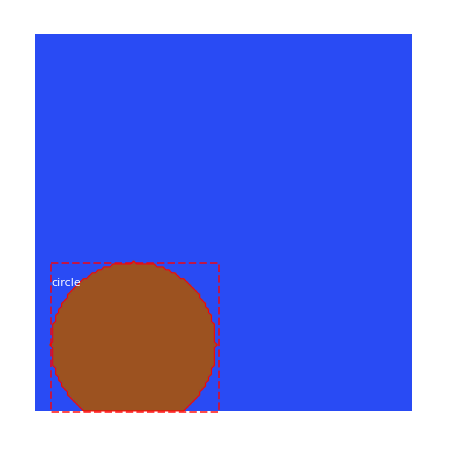

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    7.00000  max:  197.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -96.90000  max:   73.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


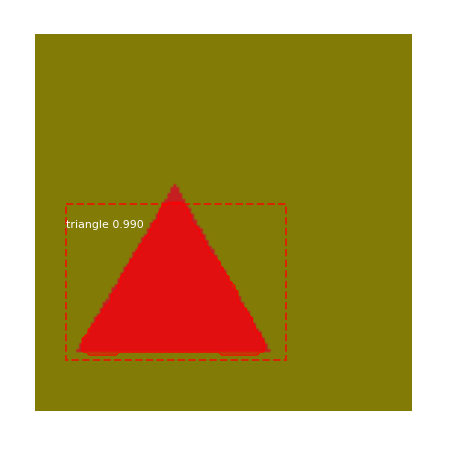

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
